<img src="../part_of_cover_bakker_post.png" width="800px">

The Python code provided below is from <br>
**Analytical Groundwater Modeling: Theory and Applications Using Python** <br>
by *Mark Bakker and Vincent Post* <br>
ISBN 9781138029392

The book is published by CRC press and is available [here](https://www.routledge.com/Analytical-Groundwater-Modeling-Theory-and-Applications-using-Python/Bakker-Post/p/book/9781138029392).

This Notebook is provided under the [MIT license](https://github.com/pythongroundwaterbook/analytic_gw_book/blob/main/LICENSE). 

<p>© 2022 Mark Bakker and Vincent Post</p>

# Steady two-dimensional flow to wells in uniform background flow

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 3) # set default figure size
plt.rcParams["contour.negative_linestyle"] = 'solid' # set default line style
plt.rcParams["figure.autolayout"] = True # same at tight_layout after every plot

## A single well in uniform background flow

In [2]:
# parameters
xw = 0 # x-location of well, m
yw = 0 # y-location of well, m
Q = 80 # discharge of well, m^3/d
U = 0.5 # uniform flow in x-direction, m^2/d

In [3]:
# solution
xs = xw + Q / (2 * np.pi * U)
xg, yg = np.meshgrid(np.linspace(-200, 100, 100), np.linspace(-100, 100, 100))
psi = Q / (2 * np.pi) * np.arctan2(yg, xg) - U * yg

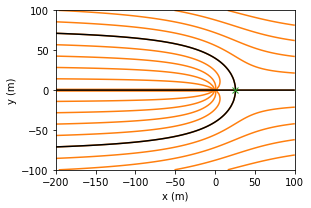

In [4]:
# basic streamline plot, left graph
plt.subplot(111, aspect=1)
plt.contour(xg, yg, psi, 10, colors='C1', linestyles='-')
plt.contour(xg, yg, psi, [-U * yw], colors='k', linestyles='-') # envelope
plt.plot(xs, 0, 'C2x'); # stagnation point
plt.xlabel('x (m)')
plt.ylabel('y (m)');

In [5]:
# additional parameters
n = 0.3 # porosity, -
H = 20 # aquifer thickenss, m
rw = 0.3 # radius of well, m
tmax = 10 * 365 # total travel time, d
t = np.arange(0, 10 * 365 + 1, 365 / 20) # times pathline is returned, d

In [6]:
# functions
def vxvy(t, xy, xw=0, yw=0):
    x, y = xy
    rsq = (x - xw)**2 + (y - yw)**2
    Qx = U - Q / (2 * np.pi) * (x - xw) / rsq
    Qy = -Q / (2 * np.pi) * (y - yw) / rsq
    return np.array([Qx, Qy]) / (n * H)

def reached_well(t, xy):
    return np.sqrt((xy[0] - xw) ** 2 + (xy[1] - yw) ** 2) - rw

reached_well.terminal = True # specify the terminal attribute

In [7]:
# pathline solution
from scipy.integrate import solve_ivp
path0 = solve_ivp(vxvy, (0, tmax), y0=[-200, 50], t_eval=t, events=reached_well)
print('path0 message:', path0.message)
print(f'path0 reached well after {path0.t_events[0][0] / 365: .2f} years')
print(f'path0 entered well screen at', path0.y_events)
path1 = solve_ivp(vxvy, (0, tmax), y0=[-200, 80], t_eval=t, events=reached_well)
print('path1 message:', path1.message)

path0 message: A termination event occurred.
path0 reached well after  5.57 years
path0 entered well screen at [array([[0.17610724, 0.24287083]])]
path1 message: The solver successfully reached the end of the integration interval.


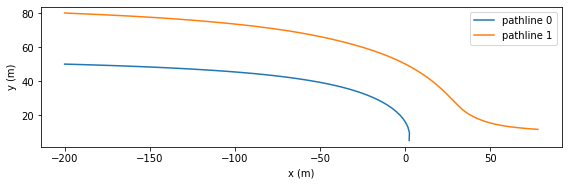

In [8]:
# basic plot
plt.subplot(111, aspect=1)
plt.plot(path0.y[0], path0.y[1], label='pathline 0')
plt.plot(path1.y[0], path1.y[1], label='pathline 1')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.legend();

## Well capture zones

In [9]:
# parameters
n = 0.25 # porosity, -
k = 20 # hydraulic conductivity, m/d
H = 15 # aquifer thickness, m
dhdx = -0.002 # gradient, -
U = -k * H * dhdx # uniform flow, m^2/d
Q = 500 # discharge of the well, m^3/d
rw = 0.3 # radius of well, m

In [10]:
# solution
# coordinates of capture zone envelope
theta = np.linspace(-3, -1e-4, 100) # bottom half of envelope
r = Q / (2 * np.pi) * theta / (U * np.sin(theta))
xcap = r * np.cos(theta)
ycap = r * np.sin(theta)
# grid inside the capture zone envelope
xg = xcap * np.ones((50, len(xcap)))
yg = np.zeros_like(xg)
for i in range(len(xcap)):
    yg[:, i] = np.linspace(ycap[i] + 1e-3, -ycap[i] - 1e-3, 50)
# travel time for all grid points inside capture zone envelope
theta = np.arctan2(yg, xg)
tgrid = -n * H * xg / U - Q * n * H / (2 * np.pi * U ** 2) * np.log(
        np.sin(theta - 2 * np.pi * U * yg / Q) / np.sin(theta))

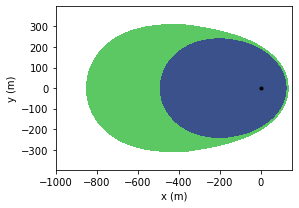

In [11]:
# basic capture zone plot
plt.subplot(111, aspect=1, xlim=(-1000, 150))
plt.plot(0, 0, 'k.')
plt.contourf(xg, yg, tgrid, [0, 5 * 362.25, 10 * 365.25])
plt.xlabel('x (m)')
plt.ylabel('y (m)');

In [12]:
# additional parameters
xw0, yw0 = 0, 0 # x,y-location well 0, m
xw1, yw1 = 100, 100 # x,y-location well 1, m

In [13]:
def vxvy(t, xy, xw=0, yw=0):
    x, y = xy
    rsq = (x - xw)**2 + (y - yw)**2
    Qx = U - Q / (2 * np.pi) * (x - xw) / rsq
    Qy = -Q / (2 * np.pi) * (y - yw) / rsq
    return np.array([Qx, Qy]) / (n * H)

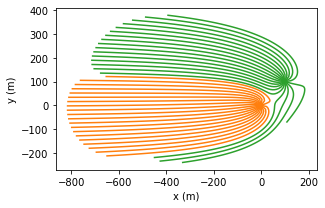

In [14]:
# solution and plot
def minvxvy(t, xy): # function vxvy from Section 7.1
    return -vxvy(t, xy, xw=xw0, yw=yw0) - vxvy(t, xy, xw=xw1, yw=yw1)

from scipy.integrate import solve_ivp
xstart = rw * np.cos(np.arange(0, 2 * np.pi, np.pi / 10)) # spaced around well
ystart = rw * np.sin(np.arange(0, 2 * np.pi, np.pi / 10)) # spaced around well
plt.subplot(111, aspect=1)
for i in range(len(xstart)):
    path = solve_ivp(minvxvy, (0, 5 * 365), [xstart[i] + xw0, ystart[i] + yw0], 
                     t_eval=np.linspace(0, 5 * 365, 100))
    plt.plot(path.y[0], path.y[1], 'C1')
    path = solve_ivp(minvxvy, (0, 5 * 365), [xstart[i] + xw1, ystart[i] + yw1], 
                     t_eval=np.linspace(0, 5 * 365, 100))
    plt.plot(path.y[0], path.y[1], 'C2')
plt.xlabel('x (m)')
plt.ylabel('y (m)');

## A well in uniform background flow near a river

In [15]:
# parameters
Q = 80 # discharge of well, m^3/d
Wu = 0.5 - 0j # complex uniform flow, m^2/d
zetaw = 0 + 0j # complex location of well, m

In [16]:
# solution
xg, yg = np.meshgrid(np.linspace(-200, 100, 100), np.linspace(-100, 100, 100))
zetag = xg + yg * 1j # grid of complex coordinates
omega1 = -Wu * zetag + Q / (2 * np.pi) * np.log(zetag - zetaw)
omega2 = -Wu * zetag + Q / (2 * np.pi) * np.log(zetaw - zetag)

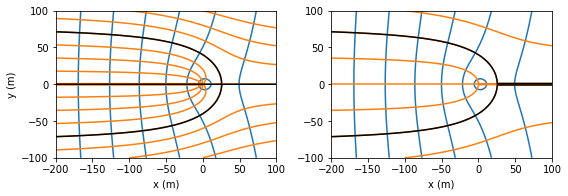

In [17]:
# basic plot of flow net
plt.subplot(121, aspect=1)
plt.contour(xg, yg, omega1.real, colors='C0')
plt.contour(xg, yg, omega1.imag, colors='C1', linestyles='-')
plt.contour(xg, yg, omega1.imag, [0], colors='k')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.subplot(122, aspect=1)
plt.contour(xg, yg, omega2.real, colors='C0')
plt.contour(xg, yg, omega2.imag, colors='C1', linestyles='-')
plt.contour(xg, yg, omega2.imag, [-40, 40], colors='k')
plt.xlabel('x (m)');

In [18]:
# parameters
dhdx = -0.001 # head gradient, -
h0 = 10 # water level in river, m
T = 100 # transmissivity, m^2/d
UL = -T * dhdx # uniform flow on left side of river, m^2/d
UR = -UL # uniform flow on right side of river, m^2/d
d = 50 # distance between well and river, m
phi0 = T * h0 # potential along the river, m^3/d
Qcr = np.pi * UL * d # critical discharge, m^3/d
print(f'{Qcr = :.2f} m^3/d')

Qcr = 15.71 m^3/d


In [19]:
# solution
def omega(x, y, Q, d=d, phi0=phi0):
    zeta = x + y * 1j
    if x <= 0:
        om = -UL * zeta + Q / (2 * np.pi) * \
             np.log((zeta + d) / (d - zeta)) + phi0
    else:
        om = -UR * zeta + phi0
    return om

omegavec = np.vectorize(omega) # vectorized version of omega function

from numpy.lib.scimath import sqrt as csqrt
xg, yg = np.meshgrid(np.linspace(-200, 50, 200), np.linspace(-100, 100, 200))
om1 = omegavec(xg, yg, Q=Qcr / 2) # Q = half critical discharge
om2 = omegavec(xg, yg, Q=2 * Qcr) # Q = twice critical discharge
zetas = csqrt(d ** 2  -  2 * Qcr * d / (np.pi * UL)) # Q = 2Qcr
ys = zetas.imag # positive y-location of stagnation point
delQ = omega(0, ys, 2 *  Qcr).imag - omega(0, -ys, 2 * Qcr).imag
print(f'fraction of water from river for Q = 2Q_cr: {delQ / (2 * Qcr):.2f}')

fraction of water from river for Q = 2Q_cr: 0.18


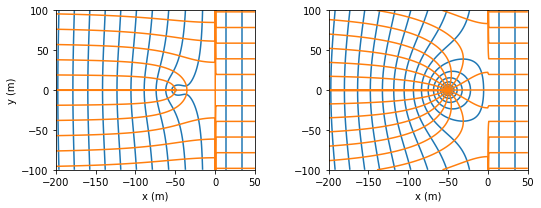

In [20]:
# basic flow nets
plt.subplot(121, aspect=1)
plt.contour(xg, yg, om1.real, np.arange(phi0 - 30, phi0 + 30, Qcr / 8), colors='C0')
plt.contour(xg, yg, om1.imag, np.arange(-2 * Qcr, 3 * Qcr, Qcr / 8), colors='C1')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.subplot(122, aspect=1)
plt.contour(xg, yg, om2.real, np.arange(phi0 - 30, phi0 + 30, Qcr / 8), colors='C0')
plt.contour(xg, yg, om2.imag, np.arange(-2 * Qcr, 3 * Qcr, Qcr / 8), colors='C1')
plt.xlabel('x (m)');

## A well in uniform background flow near a river with a leaky stream bed

<img src="figs/fig7.1.png" width=400>

In [21]:
# parameters
T = 100 # transmissivity, m^2/d
h0 = 10 # water level in river, m
UL = 0.1 # uniform flow on left side of river, m^2/d
UR = -0.1 # unform flow on right side of river, m^2/d
d = 50 # distance between well and river, m
phi0 = T * h0 # potential along the river, m^3/d
rw = 0.3 # radius of well, m
kstreambed = 0.02 # hydraulic conductivity of streambed, m/d
Hstreambed = 0.2 # thickness of streambed, m
B = 5 # width of streambed, m
c = Hstreambed / kstreambed #  resistance of stream bed, d
C = B / c # conductance of streambed, m/d
print(f'leakage factor below stream: {np.sqrt(T * c):.0f} m')

leakage factor below stream: 32 m


In [22]:
# solution
from scipy.special import exp1

def omegaresriv(x, y, Q):
    A = T / C * (UL - UR) + phi0
    z = x + y * 1j
    if x <= 0:
        Z0 = -C / (2 * T) * (z - d)
        om = Q / (2 * np.pi) * (np.log((z + d) / (d - z)) -
             np.exp(Z0) * exp1(Z0)) - UL * z + A
    else:
        Z1 = C / (2 * T) * (z + d)
        om = -Q / (2 * np.pi) * np.exp(Z1) * exp1(Z1) - UR * z + A
    return om

omegaresrivvec = np.vectorize(omegaresriv)

In [23]:
# find critical discharge
def Qxriverleft(Q, y): 
    z = -1e-6 + y * 1j
    Z0 = -C / (2 * T) * (z - d)
    W = -Q / (2 * np.pi) * (1 / (z + d) +
                            C / (2 * T) * np.exp(Z0) * exp1(Z0)) + UL
    return W.real
    
def func(Q):
    return Qxriverleft(Q, 0)

from scipy.optimize import brentq
Qcr2 = brentq(func, 0, 50) # critical discharge with bed resistance
Qcr1 = np.pi * UL * d # critical discharge no bed resistance

print(f'River bed conductance C = {C:.1f} m^2/d')
print(f'Qcr without bed resistance = {Qcr1:.2f} m^3/d')
print(f'Qcr with bed resistance = {Qcr2:.2f} m^3/d')

River bed conductance C = 0.5 m^2/d
Qcr without bed resistance = 15.71 m^3/d
Qcr with bed resistance = 25.54 m^3/d


In [24]:
xg, yg = np.meshgrid(np.linspace(-200, 50, 100), np.linspace(-100, 100, 100))
om1 = omegavec(xg, yg, Q=Qcr1) # omegavec from previous section
om2 = omegaresrivvec(xg, yg, Q=Qcr2)

In [25]:
# solution W (hidden)
def Wdis2(x, y, Q):
    z = x + y * 1j
    if x <= 0:
        Z0 = -C / (2 * T) * (z - d)
        W = -Q / (2 * np.pi) * (1 / (z + d) +
                                C / (2 * T) * np.exp(Z0) * exp1(Z0)) + QxL
    else:
        Z1 = C / (2 * T) * (z + d)
        W = -Q / (2 * np.pi) * (1 / (z + d) -
                                C / (2 * T) * np.exp(Z1) * exp1(Z1)) + QxR
    return W

Wdis2vec = np.vectorize(Wdis2)

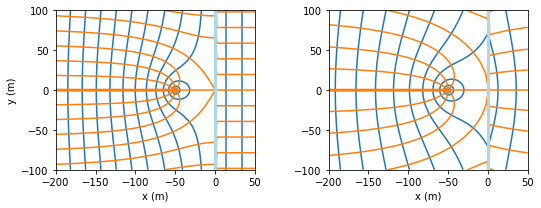

In [26]:
# basic flow nets
plt.subplot(121, aspect=1)
plt.contour(xg, yg, om1.real, np.arange(0, 2 * phi0, Qcr1 / 8), colors='C0')
plt.contour(xg, yg, om1.imag, np.arange(-2 * Qcr1, 3 * Qcr1, Qcr1 / 8), colors='C1')
plt.axvline(0, color='lightblue', lw=3)
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.subplot(122, aspect=1)
plt.contour(xg, yg, om2.real, np.arange(0, 2 * phi0, Qcr2 / 8), colors='C0')
plt.contour(xg, yg, om2.imag, np.arange(-2 * Qcr2, 3 * Qcr2, Qcr2 / 8), colors='C1')
plt.axvline(0, color='lightblue', lw=3)
plt.xlabel('x (m)');

In [27]:
# changed parameters
Q = 2 * Qcr2

# solution
def func2(ys, Q):
    return Qxriverleft(Q, ys)

ys = brentq(func2, 0, 2 * d, args=(Q))
print(f'point on the river where Qx equals zero: {ys:.2f} m')

point on the river where Qx equals zero: 57.44 m


In [28]:
print(f'head at origin: {omegaresriv(0, 0, Q).real / T:.2f} m')
print(f'head at well: {omegaresriv(-d + rw, 0, Q).real / T:.2f} m')

head at origin: 10.25 m
head at well: 9.87 m


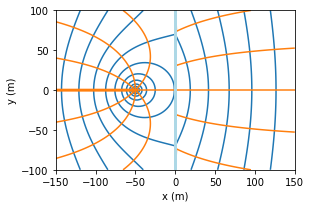

In [29]:
# basic flow nets
xg, yg = np.meshgrid(np.linspace(-150, 150, 100), np.linspace(-100, 100, 100))
om3 = omegaresrivvec(xg, yg, Q=2 * Qcr2)
plt.subplot(111, aspect=1)
plt.contour(xg, yg, om3.real, np.arange(0, 2 * phi0, 2 * Qcr1 / 8), colors='C0')
plt.contour(xg, yg, om3.imag, np.arange(-2 * Qcr2, 3 * Qcr2, 2 * Qcr2 / 8), colors='C1')
plt.axvline(0, color='lightblue', lw=3)
plt.xlabel('x (m)')
plt.ylabel('y (m)');

## A well in uniform background flow near the coast

In [30]:
# parameters
rw = 0.3 # radius of well, m
k = 40 # hydraulic conductivity, m/d
zb = -20 # elevation of bottom of aquifer, m
rhof = 1000 # density of fresh water, kg/m^3
rhos = 1025 # density of salt water, kg/m^3
U = 1 # uniform flow in x-direction, m^2/d
d = 1000 # dischance of well from coast line, m
Qcr = np.pi * U * d # critical discharge from well near river, m^3/d
Q = Qcr / 2 # discharge of well, m^3/d
print(f'dischage of well: {Q:.2f} m^3/d')

dischage of well: 1570.80 m^3/d


In [31]:
# solution
alpha = rhof / (rhos - rhof) # alpha factor
phitoe = 0.5 * k * (alpha + 1) / alpha ** 2 * zb ** 2
xtoe = -phitoe / U # toe in the absence of pumping

def omega(x, y, Q):
    zeta = x + y * 1j
    om = Q / (2 * np.pi) * np.log((zeta + d) / (d - zeta)) - U * zeta
    return om

xg, yg = np.meshgrid(np.linspace(-1200, 0, 120), np.linspace(-500, 500, 101))
om = omega(xg, yg, Q)

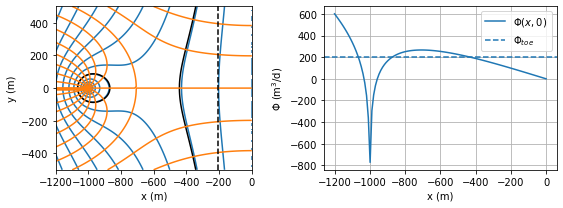

In [32]:
# basic flow net and potential along y=0
plt.subplot(121, aspect=1)
plt.contour(xg, yg, om.real, np.arange(-2000, 2000, 100), colors='C0')
plt.contour(xg, yg, om.real, [phitoe], colors='k')
plt.contour(xg, yg, om.imag, np.arange(-2000, 2000, 100), colors='C1')
plt.axvline(xtoe, color='k', linestyle='--')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.subplot(122) # potential along y=0
plt.plot(xg[0], om.real[50], label=r'$\Phi(x,0)$')
plt.axhline(phitoe, ls='--', label=r'$\Phi_{toe}$')
plt.legend()
plt.xlabel('x (m)')
plt.ylabel(r'$\Phi$ (m$^3$/d)')
plt.grid();

In [33]:
def func(Q):
    xs = -np.sqrt(d ** 2 - Q * d / (np.pi * U))
    return omega(xs, 0, Q).real - phitoe

from scipy.optimize import brentq
Qmax = brentq(func, 1, np.pi * U * d)
print(f'maximum discharge: {Qmax:.2f} m^3/d')
print(f'Qmax as fraction of Qcr of Section 7.3: {Qmax / Qcr:.2f}')
om1 = omega(xg, yg, Qmax)

maximum discharge: 1803.22 m^3/d
Qmax as fraction of Qcr of Section 7.3: 0.57


In [34]:
xg, yg = np.meshgrid(np.linspace(-1200, 0, 120), np.linspace(-500, 500, 101))
om = omega(xg, yg, Qmax)

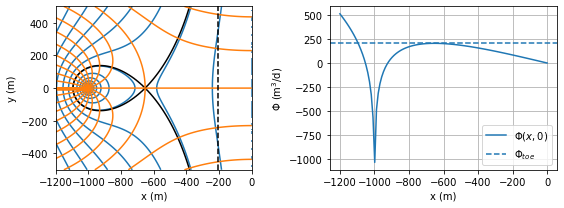

In [35]:
# basic flow net and potential along y=0
plt.subplot(121, aspect=1)
plt.contour(xg, yg, om.real, np.arange(-2000, 2000, 100), colors='C0')
plt.contour(xg, yg, om.real, [phitoe], colors='k')
plt.contour(xg, yg, om.imag, np.arange(-2000, 2000, 100), colors='C1')
plt.axvline(xtoe, color='k', linestyle='--')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.subplot(122) # potential along y=0
plt.plot(xg[0], om.real[50], label=r'$\Phi(x,0)$')
plt.axhline(phitoe, ls='--', label=r'$\Phi_{toe}$')
plt.legend()
plt.xlabel('x (m)')
plt.ylabel(r'$\Phi$ (m$^3$/d)')
plt.grid();